# Main Script For Project Miniblock

## First: Set up the head directory

In [1]:
from pathlib import Path
import sys
from os.path import join
current_path = Path.cwd()

# look through all parents
for parent in current_path.parents:
    if parent.name == "project_miniblock":
        project_dir = parent
        break
else:
    raise FileNotFoundError("Could not find a parent folder named 'project_miniblock'.")

glmdir = project_dir.parent.parent # in my case this is true might not be true for you 
sys.path.append(join(glmdir, 'GLMsingle/python'))
sys.path.append(join(glmdir, 'fracridge/fracridge'))

from preprocessing import get_design_matrices, get_motion_parameters, accuracies_functional, accuracies_localizer
subjects = [f"{i:02d}" for i in range(1,23)]

## Preprocessing

### Create design matrices for GLMSingle

In [ ]:
get_design_matrices(project_dir, subjects)

### Create Plots for motion parameters and check excessive motion

In [ ]:
subjects = ["09"]
get_motion_parameters(project_dir, subjects)

### Get accuracies for functional runs

In [4]:
accuracy_df = accuracies_functional(project_dir, subjects)
localizer_acc_df = accuracies_localizer(project_dir, subjects)

## Run GLM Single

### Functional data

In [ ]:
from preprocessing import glm_single_func
#subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
subjects  = ["09"]
outputs = [0,1,0,1]

glm_single_func(project_dir, subjects, outputs)

### Localizer data

In [ ]:
from preprocessing import glm_single_loc
subjects = [f"{i:02d}" for i in range(1, 23) if i not in [9, 16]]
outputs = [0,1,0,1]

glm_single_loc(project_dir, subjects, outputs)

### Move the files into the GLM directory and rename them

In [ ]:
from os.path import join
import os

output_dir = join(project_dir, "miniblock/Outputs")

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9,16]]
designs = ["er", "sus", "miniblock"]
smooths = ["sm_2_vox", "unsmoothed"]
# make directory 
glm_dir = join(output_dir, "GLMSingle_Outputs")
os.makedirs(glm_dir, exist_ok=True)

for sub in subjects:
    for design in designs:
        for smoothing in smooths:
            # Original file path
            src_path = join(output_dir, f"sub-{sub}",f"{smoothing}_sub-{sub}_{design}", "TYPED_FITHRF_GLMDENOISE_RR.npy")
            
            # New file name
            new_filename = f"{smoothing}_sub-{sub}_{design}_TYPED_FITHRF_GLMDENOISE_RR.npy"
            
            # Destination path
            dst_path = join(glm_dir, new_filename)
            
            # Move & rename
            if os.path.exists(src_path):
                os.rename(src_path, dst_path)
                print(f"Moved: {src_path} -> {dst_path}")
            else:
                print(f"File does not exist: {src_path}")




### Move the files into the GLMSingle localizer directory

In [ ]:
from os.path import join
import os

output_dir = join(project_dir, "miniblock/Outputs")

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9,16]]
designs = ["er", "sus", "miniblock"]
smooths = ["sm_2_vox", "unsmoothed"]
# make directory 
glm_dir = join(output_dir, "GLMSingle_Outputs/localizer")
os.makedirs(glm_dir, exist_ok=True)

for sub in subjects:
    for smoothing in smooths:
        # Original file path
        src_path = join(output_dir, "localizer",f"sub-{sub}",f"{smoothing}_sub-{sub}_localizer", "TYPED_FITHRF_GLMDENOISE_RR.npy")
        
        # New file name
        new_filename = f"{smoothing}_sub-{sub}_TYPED_FITHRF_GLMDENOISE_RR.npy"
        
        # Destination path
        dst_path = join(glm_dir, new_filename)
        
        # Move & rename
        if os.path.exists(src_path):
            os.rename(src_path, dst_path)
            print(f"Moved: {src_path} -> {dst_path}")
        else:
            print(f"File does not exist: {src_path}")




## Masking

### Preparation

#### Unzip JuBrain masks

In [8]:
from masking import unzip_file
import os

maskdir = join(project_dir, "Code/JuBrain_masks")
files = os.listdir(maskdir)
for file in files: 
    if ".gz" in file:
        unzip_file(join(maskdir, file), join(maskdir, file[:-3]))

Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/occipital_cortex.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/occipital_cortex.nii
Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/fusiform_gyrus.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/fusiform_gyrus.nii
Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/VRV.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/VRV.nii
Unzipped: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/early_visual_cortex.nii.gz -> /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/early_visual_cortex.nii


#### Resample JuBrain masks

In [9]:
from masking import resample_and_save_mask
import os
maskdir = join(project_dir, "Code/JuBrain_masks")
files = os.listdir(maskdir)
for unzipped_file in files: 
    if ".gz" not in unzipped_file and ".nii" in unzipped_file: 
        resample_and_save_mask(project_dir=project_dir,
                               input_mask_path=join(maskdir, unzipped_file),
                               output_mask_path=join(maskdir, unzipped_file[:-4]+ "_resampled.nii"))

Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/fusiform_gyrus_resampled.nii
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/early_visual_cortex_resampled.nii
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/occipital_cortex_resampled.nii
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/Code/JuBrain_masks/VRV_resampled.nii


#### Resample fMRIPrep masks

In [21]:
import os
import re

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
whole_brain_mask = re.compile(r'.*space-MNI152NLin2009cAsym_desc-brain_mask\.nii\.gz$')
grey_matter_mask = re.compile(r'.*space-MNI152NLin2009cAsym_label-GM_probseg\.nii\.gz$')

for sub in subjects:
    anatdir = os.path.join(project_dir, f"miniblock/derivatives/sub-{sub}/anat")
    for file in os.listdir(anatdir):
        if whole_brain_mask.match(file):
            whole_brain_file = os.path.abspath(os.path.join(anatdir, file))
            resample_and_save_mask(project_dir=project_dir,
                               input_mask_path=join(anatdir, whole_brain_file),
                               output_mask_path=join(anatdir, whole_brain_file[:-7]+ "_resampled.nii.gz"))

        elif grey_matter_mask.match(file):
            grey_matter_file = os.path.abspath(os.path.join(anatdir, file))
            resample_and_save_mask(project_dir=project_dir,
                               input_mask_path=join(anatdir, grey_matter_file),
                               output_mask_path=join(anatdir, grey_matter_file[:-7]+ "_resampled.nii.gz"))


Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_desc-brain_mask_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_label-GM_probseg_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-02/anat/sub-02_space-MNI152NLin2009cAsym_label-GM_probseg_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-02/anat/sub-02_space-MNI152NLin2009cAsym_desc-brain_mask_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-03/anat/sub-03_space-MNI152NLin2009cAsym_label-GM_probseg_resampled.nii.gz
Resampled mask saved to: /Users/danieljanini/Documents/project_miniblock/miniblock/derivatives/sub-03/anat/sub-03_space-MNI152NLin20

#### Generate Group Mask for Decoding

In [2]:
from masking import get_group_mask

get_group_mask(project_dir=project_dir)

### All ROIs

#### Visually Responsive Voxels

In [3]:
from masking import get_visually_responsive_voxels
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_visually_responsive_voxels(project_dir=project_dir, subjects=subjects)

#### Early Visual Cortex

In [2]:
from masking import get_evc_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_evc_mask(project_dir=project_dir, subjects=subjects)

#### Fusiform Face Area

In [ ]:
from masking import get_FFA_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_FFA_mask(project_dir=project_dir, subjects=subjects)

#### Parahippocampal Place Area

In [2]:
from masking import get_PPA_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_PPA_mask(project_dir=project_dir, subjects=subjects)

#### Extrastriate Body Area

In [2]:
from masking import get_EBA_mask
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
get_EBA_mask(project_dir=project_dir, subjects=subjects)

## Reliability

### Get Whole-Brain Maps

In [ ]:
from reliability import get_whole_brain_rel_maps

subjects = [f"{i:02d}" for i in range(1,2) if i not in [9, 16]]
get_whole_brain_rel_maps(project_dir, subjects)

In [ ]:
from reliability import gather_reliability_maps
from os.path import exists
import pandas as pd

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]
if exists(join(project_dir, "miniblock/Outputs/reliability/reliability_results_all.csv")):
    results_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/reliability_results_all.csv"))
else: 
    results_df = gather_reliability_maps(project_dir, subjects, ROIs)

### Side Analyses

#### Progression analysis

In [ ]:
from reliability import reliability_progression_between_runs
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]

reliability_progression_between_runs(project_dir, subjects)


In [4]:
from os.path import exists
import pandas as pd
from reliability import gather_progession_between

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]

if exists(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_between/reliability_progression_between.csv")):
    progression_between_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_between/reliability_progression_between.csv"))
else: 
    progression_between_df = gather_progession_between(project_dir, subjects, ROIs) 


In [ ]:
from reliability import reliability_progression_within_runs
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]

reliability_progression_within_runs(project_dir, subjects)

In [2]:
from os.path import exists
import pandas as pd
from reliability import gather_progession_within

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]

if exists(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_within/reliability_progression_within.csv")):
    progression_within_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/progression_analysis_within/reliability_progression_within.csv"))
else: 
    progression_within_df = gather_progession_within(project_dir, subjects, ROIs) 

##### Progression within visualizations

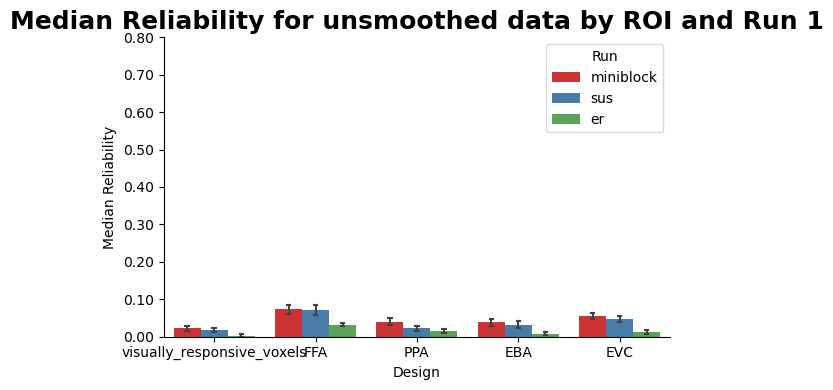

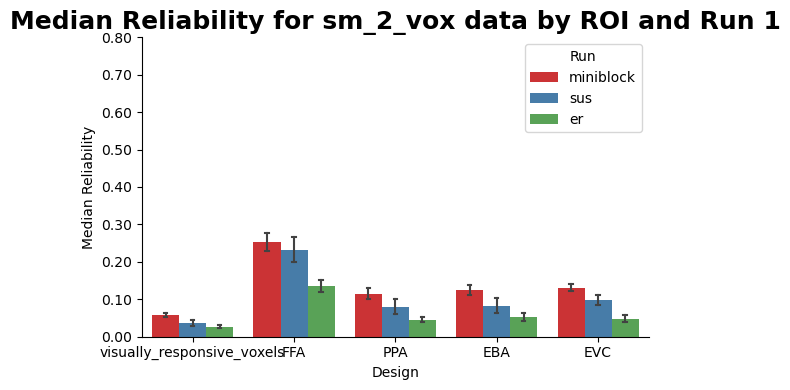

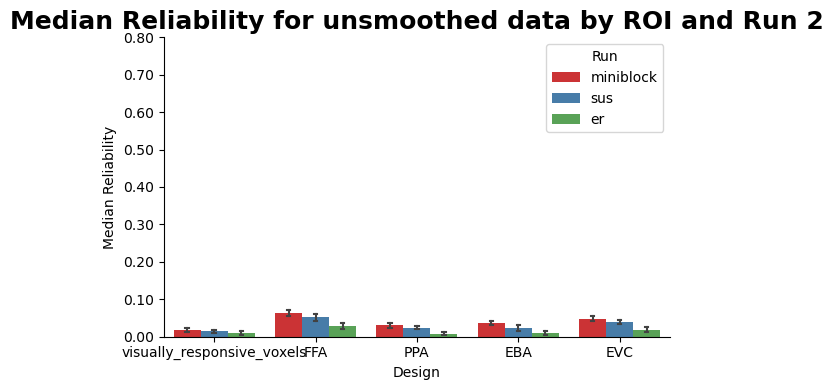

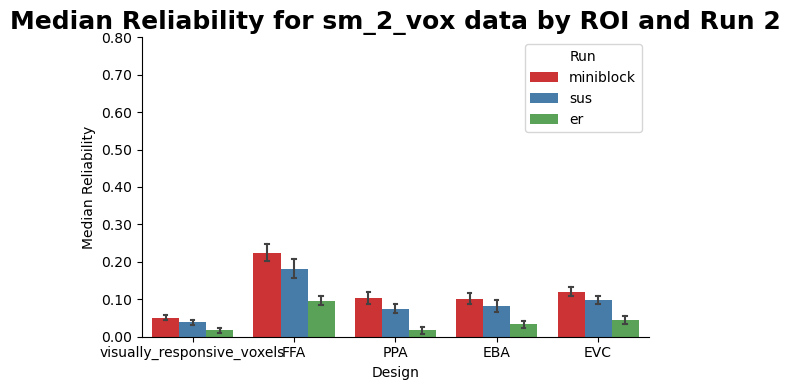

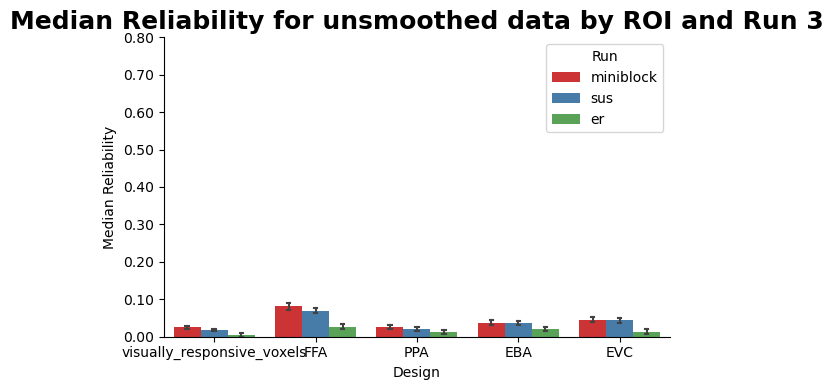

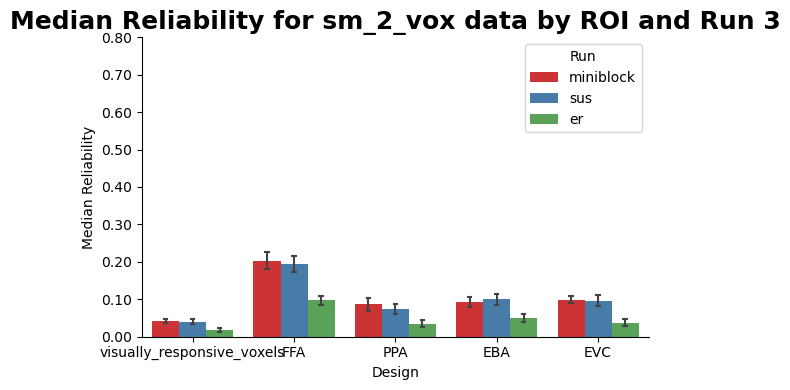

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

smooths = ["unsmoothed", "sm_2_vox"]

# Optional: custom palette
palette = sns.color_palette("Set1")[:3]

ROI_dir = {
    "visually_responsive_voxels": "Visually Responsive Voxels",
    "EVC": "Early Visual Cortex",
    "EBA": "Extrastriate Body Area",
    "FFA": "Fusiform Face Area",
    "PPA": "Parahippocampal Place Area"
}

smoothed_df = progression_within_df[progression_within_df["smoothing"] == "unsmoothed"]

for r in range(1,4):
    for smoothing in smooths:
        
        smoothed_df = progression_within_df[progression_within_df["smoothing"] == smoothing]
        run_df = smoothed_df[smoothed_df["run"] == r]

        g = sns.catplot(
            data=run_df,
            kind="bar",
            x="ROI",
            y="median_rel",
            hue="runtype",
            height=4,
            aspect=1.2,
            palette=palette,
            errorbar="se",
            capsize=0.1,
            err_kws={'linewidth': 1.5}
        )

        # Set y-axis limits and ticks on the main axis
        ax = g.ax
        ax.set_ylim(0, 0.8)  # set min and max y-axis limits, adjust to your needs

        # Optional: format y-axis labels
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

        g.set_titles(f"{r}", size=16, weight="bold")
        g.set_axis_labels("Design", "Median Reliability")
        g.set_xticklabels()
        g._legend.remove()


        plt.title(f"Median Reliability for {smoothing} data by ROI and Run {r}", fontsize=18, fontweight="bold")
        plt.legend(title="Run")
        plt.tight_layout()
        plt.show()


#### Noise Ceiling as in NSD Paper

In [2]:
from reliability import noise_ceilings
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]

noise_ceilings(project_dir, subjects)

In [7]:
from reliability import gather_noise_ceilings
from os.path import exists
import pandas as pd

subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]

if exists(join(project_dir, "miniblock/Outputs/reliability/noise_ceilings/df_noise_ceilings.csv")):
    noise_ceilings_df = pd.read_csv(join(project_dir, "miniblock/Outputs/reliability/noise_ceilings/df_noise_ceilings.csv"), index_col=0)
else: 
    noise_ceilings_df = gather_noise_ceilings(project_dir, subjects, ROIs) 

##### Group results noise ceiling 

In [11]:
from statsmodels.stats.anova import AnovaRM
from scipy.stats import ttest_rel
from itertools import combinations
import pandas as pd
import statsmodels.stats.multitest as smm

ROIs = ["visually_responsive_voxels", "FFA", "PPA", "EBA", "EVC"]
smooths = ["sm_2_vox", "unsmoothed"]

significant_df = []

for ROI in ROIs:
    for smoothing in smooths:
        df = noise_ceilings_df[noise_ceilings_df["ROI"] == ROI]

        df = (
            df[df["smoothing"] == smoothing]
            .groupby(["subject", "runtype"], as_index=False)["median_nc"]
            .mean()
        )

        # Run repeated-measures ANOVA
        aov = AnovaRM(data=df, depvar='median_nc', subject='subject', within=["runtype"])
        aov_res = aov.fit()
        print(f"\n--- {ROI}, {smoothing} ---")
        print(aov_res)

        # Pairwise comparisons
        runtype_conditions = df['runtype'].unique()
        comparisons = list(combinations(runtype_conditions, 2))

        pvals = []
        results = []

        df_wide = df.pivot(index='subject', columns='runtype', values='median_nc')

        for cond1, cond2 in comparisons:
            t_stat, p_val = ttest_rel(df_wide[cond1], df_wide[cond2])
            pvals.append(p_val)
            results.append((cond1, cond2, t_stat, p_val))

        _, pvals_corrected, _, _ = smm.multipletests(pvals, method='fdr_bh')

        # Build row dict
        row = {"ROI": ROI, "smoothing": smoothing}

        for i, (cond1, cond2, t_stat, p_val) in enumerate(results):
            label = f"{cond1}_vs_{cond2}"
            row[f"{label}_t"] = t_stat
            row[f"{label}_p_uncorrected"] = p_val
            row[f"{label}_p_corrected"] = pvals_corrected[i]

        significant_df.append(row)

# Convert to DataFrame
significant_df = pd.DataFrame(significant_df)



--- visually_responsive_voxels, sm_2_vox ---
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype 10.2034 2.0000 38.0000 0.0003


--- visually_responsive_voxels, unsmoothed ---
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype  9.5050 2.0000 38.0000 0.0004


--- FFA, sm_2_vox ---
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype 22.0434 2.0000 38.0000 0.0000


--- FFA, unsmoothed ---
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype 18.1285 2.0000 38.0000 0.0000


--- PPA, sm_2_vox ---
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype  7.1848 2.0000 38.0000 0.0023


--- PPA, unsmoothed ---
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype  0.1221 2.0000 38.0

In [12]:
significant_df.head()

,ROI,smoothing,er_vs_miniblock_t,er_vs_miniblock_p_uncorrected,er_vs_miniblock_p_corrected,er_vs_sus_t,er_vs_sus_p_uncorrected,er_vs_sus_p_corrected,miniblock_vs_sus_t,miniblock_vs_sus_p_uncorrected,miniblock_vs_sus_p_corrected
0,visually_responsive_voxels,sm_2_vox,-4.660477,0.000170,0.000511,-2.581146,0.018306,0.027459,1.733640,0.099180,0.099180
1,visually_responsive_voxels,unsmoothed,-3.979078,0.000804,0.002411,-3.045533,0.006655,0.009982,1.079120,0.294044,0.294044
2,FFA,sm_2_vox,-6.528309,0.000003,0.000009,-4.499604,0.000245,0.000368,1.049713,0.307019,0.307019
3,FFA,unsmoothed,-5.600149,0.000021,0.000064,-3.883234,0.001000,0.001501,1.608247,0.124271,0.124271
4,PPA,sm_2_vox,-4.462051,0.000267,0.000802,-2.162075,0.043579,0.065369,1.265542,0.220977,0.220977


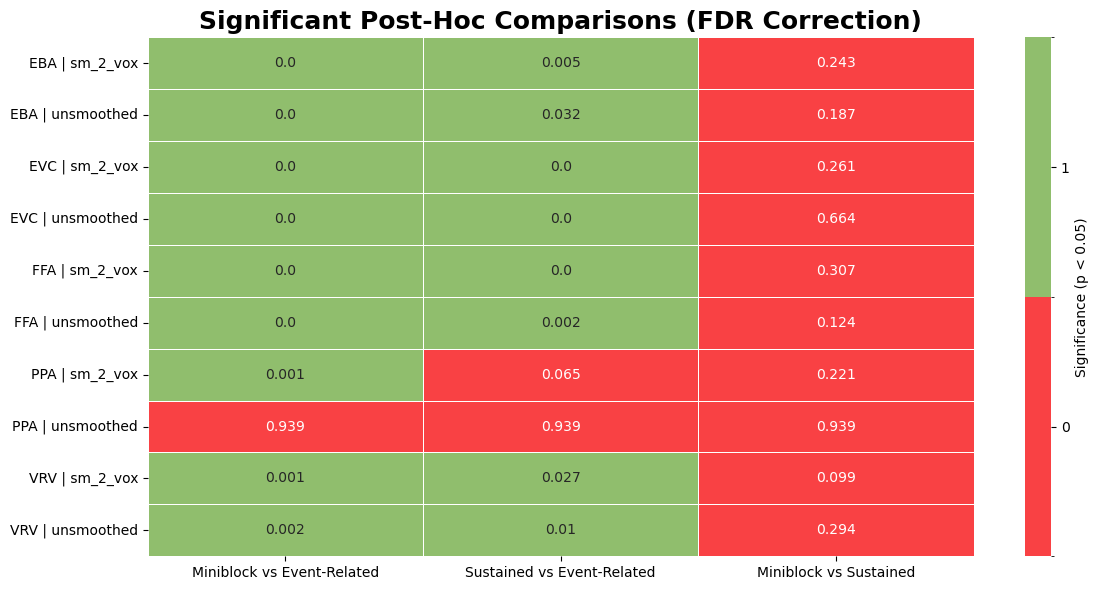

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

significant_df = significant_df[["ROI", "smoothing", "er_vs_miniblock_p_corrected", "er_vs_sus_p_corrected", "miniblock_vs_sus_p_corrected"]]

# 1. Melt the dataframe to long format for seaborn
melted_df = significant_df.melt(id_vars=["ROI", "smoothing"], 
                                 value_vars=[col for col in significant_df.columns if "p_" in col],
                                 var_name="comparison", 
                                 value_name="p_value")

# 2. Combine ROI and smoothing for clearer labels
melted_df["ROI_smooth"] = melted_df["ROI"] + " | " + melted_df["smoothing"]

# 3. Pivot to matrix format
heatmap_data = melted_df.pivot(index="ROI_smooth", columns="comparison", values="p_value")

heatmap_data = heatmap_data.rename(index={
    "visually_responsive_voxels | sm_2_vox": "VRV | sm_2_vox",
    "visually_responsive_voxels | unsmoothed": "VRV | unsmoothed"
})

# 1. Create a mask of the data below/above 0.05
threshold = 0.05

# 2. Convert p-values to binary (0 = not significant, 1 = significant)
significance = (heatmap_data < threshold).astype(int)

# 3. Create a 2-color colormap: 0 = red (not sig), 1 = green (sig)
cmap = ListedColormap(["#f94144", "#90be6d"])  # red = not sig, green = sig
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

# 4. Plot the heatmap using binary significance for color, but annotate with real p-values
plt.figure(figsize=(12, 6))
sns.heatmap(significance,
            annot=heatmap_data.round(3),  # show actual p-values
            fmt="",
            cmap=cmap,
            norm=norm,
            cbar_kws={"ticks": [0, 1], "label": f"Significance (p < {threshold})"},
            linewidths=0.5)

plt.title("Significant Post-Hoc Comparisons (FDR Correction)", fontsize=18, fontweight="bold")
custom_labels = ["Miniblock vs Event-Related", "Sustained vs Event-Related", "Miniblock vs Sustained"]
plt.xticks(ticks=np.arange(len(custom_labels)) + 0.5,  # heatmap ticks are centered
           labels=custom_labels)
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()

## RSA

### Side Analyses

In [2]:
from RSA import PCA_all_trials, PCA_CV

In [3]:
subjects = [f"{i:02d}" for i in range(1,23) if i not in [9, 16]]
ROIs  = ["FFA", "PPA", "EBA", "EVC"]
runtypes = ["sus", "miniblock", "er"]

explained_variance = PCA_all_trials(project_dir, subjects, ROIs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
mean_over_part = explained_variance.mean(axis=0)
for runtype in range(3):
    for ROI in range(4):
        plt.figure(figsize=(8,5))
        plt.plot(np.arange(1, 41), mean_over_part[runtype, ROI,:], 'o-', label='Explained variance ratio')
        plt.xlabel('Principal component')
        plt.ylabel('Variance explained')
        plt.title(f'Scree plot of RSM PCA: {runtypes[runtype]} and {ROIs[ROI]}')
        plt.grid(True)
        plt.show()

In [7]:
explained_variance_train, explained_variance_test, _ = PCA_CV(project_dir, subjects, ROIs)

In [ ]:
mean_over_part = explained_variance_test.mean(axis=0)
for runtype in range(3):
    for ROI in range(4):
        for step in range(6):
                plt.figure(figsize=(8,5))
                plt.plot(np.arange(1, 41), mean_over_part[runtype, ROI, step, :], 'o-', label='Explained variance ratio')
                plt.xlabel('Principal component')
                plt.ylabel('Variance explained')
                plt.title(f'Scree plot of RSM PCA: {runtypes[runtype]} and {ROIs[ROI]} and CV-Step {step}')
                plt.grid(True)
                plt.show()